In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, RandomRotation, RandomTranslation, RandomFlip, RandomContrast
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Input,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.config import list_physical_devices
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from numpy import load, sum, array
from numpy.random import shuffle
from tensorflow.keras.callbacks import CSVLogger
from time import time
from numpy import ceil, arange
from cv2 import imread, resize, IMREAD_COLOR
import matplotlib.pyplot as plt


In [ ]:
print("Num GPUs Available: ", len(list_physical_devices('GPU')))
CLASSES = 3
BATCH_SIZE = 32
RED = 'efficientnet'    # vgg16, efficientnet, xception
pchs = 40
lr=0.001
if RED == 'vgg16':
    MIN_SIZE = 224
elif RED == 'efficientnet':
    MIN_SIZE = 224
elif RED == 'xception':
    MIN_SIZE = 299

from google.colab import drive
drive.mount('/gdrive')
PATH = '/gdrive/My Drive/AffectNet'

FILTRAR = 'filt'             # string -> filt, nofilt
HOMO = 'balan'                # string -> balan, nobalan

class AffectNetSequence(Sequence):
    # Clase para realizar una carga de imagenes por lotes debido a la magnitud
    # del dataset
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.indexes = arange(len(self.x))

    def __len__(self):
        return int(ceil(len(self.x) / self.batch_size))


    def __getitem__(self, idx):
        index = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[index]
        batch_y = self.y[index]

        return array([resize(imread(file_name, IMREAD_COLOR),
                                (MIN_SIZE,MIN_SIZE))
                                for file_name in batch_x], dtype=float), \
               array(batch_y, dtype = int)

    def on_epoch_end(self):
        shuffle(self.indexes)

img_augmentation = Sequential(
    [
        RandomRotation(factor=0.10),
        RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

Num GPUs Available:  1
Mounted at /gdrive


In [ ]:
input = Input(shape=(MIN_SIZE, MIN_SIZE, 3))
x = img_augmentation(input)
if RED == 'vgg16':
    base_model = vgg16(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_tensor=x,
        include_top=False)

elif RED == 'efficientnet':
    base_model = EfficientNetB0(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_tensor=x,
        include_top=False)
    
elif RED == 'xception':
    base_model = Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_tensor=x,
        include_top=False)
elif RED == 'mobilenetv2':
    base_model = mobilenetv2(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_tensor=x,
        include_top=False)
    
print(range(221))
for i in range(221):
    base_model.layers[i].trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
dropout_rate = 0.2
x = Dropout(dropout_rate)(x)
output = Dense(CLASSES, activation="softmax")(x)

model = Model(inputs=input, outputs=output)
model.compile(optimizer=Adam(learning_rate=lr,
                              beta_1=0.9,
                              beta_2=0.999,
                              epsilon=1e-07),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
range(0, 221)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
_______________

In [ ]:
x_train = load(PATH + '/x_train_data_' + str(CLASSES) + 'classes_' + FILTRAR + '_' + HOMO + '_' + 'size=' + str(MIN_SIZE) + '.npy', allow_pickle=True)
x_val = load(PATH + '/x_val_data_' + str(CLASSES) + 'classes_' + FILTRAR + '_' + HOMO + '_' + 'size=' + str(MIN_SIZE) + '.npy', allow_pickle=True)
y_train = load(PATH + '/y_train_data_' + str(CLASSES) + 'classes_' + FILTRAR + '_' + HOMO + '_' + 'size=' + str(MIN_SIZE) + '.npy', allow_pickle=True)
y_val = load(PATH + '/y_val_data_' + str(CLASSES) + 'classes_' + FILTRAR + '_' + HOMO + '_' + 'size=' + str(MIN_SIZE) + '.npy', allow_pickle=True)
y_t = sum(y_train, axis=0)
y_v = sum(y_val, axis=0)
print("Etiquetas de entrenamiento: " + str(y_t))
print("Etiquetas de evaluacion: " + str(y_v))
print("Imagenes de entrenamiento: " + str(len(x_train)))
print("Imagenes de validación: " + str(len(x_val)))
print('Ratio train-val: ' + str(int(100*((len(x_val))/((len(x_train))+(len(x_val)))))) + '%')

train_generator = AffectNetSequence(x_train, y_train, BATCH_SIZE)
val_generator = AffectNetSequence(x_val, y_val, BATCH_SIZE)


Etiquetas de entrenamiento: [34386 34406 34408]
Etiquetas de evaluacion: [8614 8594 8592]
Imagenes de entrenamiento: 103200
Imagenes de validación: 25800
Ratio train-val: 20%


In [ ]:
#Transfer Learning

start_time = time()
history = model.fit(
    x=train_generator,
    epochs=pchs,
    verbose=1,
    validation_data=val_generator,
    initial_epoch=0,
    steps_per_epoch=int(len(x_train)/BATCH_SIZE),
    max_queue_size=8,
    workers=4,
    use_multiprocessing=True
    )
end_time = time()
execution_time = round((end_time - start_time)/3600, 2)
print(str(execution_time))

model.save_weights(PATH + '/' + RED + '_learningrate=' + str(lr) + '_' + str(CLASSES) + 'classes_epoch=' + str(pchs) + '_time'+ str(execution_time) + '_' + FILTRAR + '_' + HOMO + '_transfer_learning' + '.h5', save_format="h5")


Epoch 1/40
3225/3225 [==============================] - 24127s 7s/step - loss: 0.8444 - accuracy: 0.6488 - val_loss: 0.6687 - val_accuracy: 0.7102
Epoch 2/40
3225/3225 [==============================] - 1028s 319ms/step - loss: 0.7033 - accuracy: 0.6936 - val_loss: 0.6286 - val_accuracy: 0.7218
Epoch 3/40
3225/3225 [==============================] - 1033s 320ms/step - loss: 0.6750 - accuracy: 0.7083 - val_loss: 0.6276 - val_accuracy: 0.7287
Epoch 4/40
3225/3225 [==============================] - 1014s 314ms/step - loss: 0.6550 - accuracy: 0.7175 - val_loss: 0.6112 - val_accuracy: 0.7342
Epoch 5/40
3225/3225 [==============================] - 1002s 310ms/step - loss: 0.6421 - accuracy: 0.7234 - val_loss: 0.6134 - val_accuracy: 0.7354
Epoch 6/40
3225/3225 [==============================] - 1043s 323ms/step - loss: 0.6291 - accuracy: 0.7288 - val_loss: 0.5940 - val_accuracy: 0.7429
Epoch 7/40
3225/3225 [==============================] - 1058s 328ms/step - loss: 0.6162 - accuracy: 0.7375 -

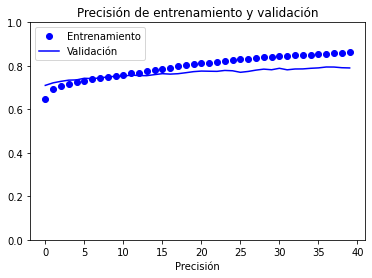

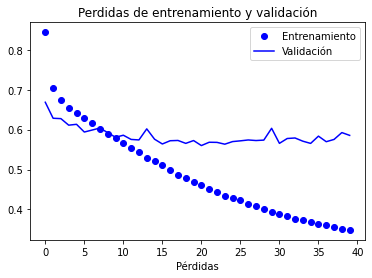

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Validación')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel("Época")
plt.xlabel("Precisión")
plt.ylim(0, 1)
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.title('Perdidas de entrenamiento y validación')
plt.xlabel("Época")
plt.xlabel("Pérdidas")
plt.legend()
plt.show()